In [18]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from titanic.data import load

# 1. Loading data

In [3]:
datas = load("data/"); klist = list(datas.keys()); klist

['test.csv', 'train.csv', 'gender_submission.csv']

In [4]:
train = datas[klist[1]]
Xtest = datas[klist[0]]
Ytest = datas[klist[2]].Survived

In [5]:
# NaN Sources
train.columns[train.isna().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

# 2. Preprocessing

In [8]:
from titanic.preprocessing import create_matrix, get_passager_title, is_child, has_surname, clean_testset

In [9]:
# The train set
Xtrain = create_matrix(
        [train.SibSp,train.Fare,train.Parch,train.Pclass,is_child(train.Age),
         train.Sex,get_passager_title(train.Name), has_surname(train.Name)],
        [False,False,False,True,True,True, True, True])
Ytrain = train.Survived

In [10]:
# The test set
XtestX = create_matrix(
        [Xtest.SibSp,Xtest.Fare,Xtest.Parch,Xtest.Pclass,is_child(Xtest.Age),
         Xtest.Sex,get_passager_title(Xtest.Name), has_surname(Xtest.Name)],
        [False,False,False,True,True,True, True, True])
XtestX = clean_testset(Xtrain, XtestX)

# 3. Best partition search

## 3.1 Logistic classification

In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from titanic.models import best_train_partition_search

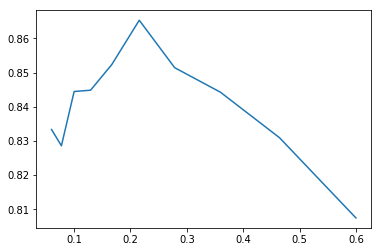

In [19]:
model_lr = LogisticRegressionCV()
test_size_grid, test_score_grid = best_train_partition_search(model_lr, Xtrain, Ytrain)
plt.plot(test_size_grid, test_score_grid)

On a meilleur score avec un split compris entre 0.2 et 0.3. Lorsqu'on compare ce score avec celui de la validation croisee on obtient 

In [27]:
model_lr.fit(Xtrain,Ytrain)
cx_score = cross_val_score(model_lr, Xtrain, Ytrain, cv=10)
{"score_cv":np.mean(cx_score),"score_split":np.mean(test_score_grid)}

{'score_cv': 0.8328180683236862, 'score_split': 0.8402847652462683}

On obtient presques les meme scores. Ainsi la cross-validation suffit largement pour choisir le bon parametre 

## 3.2 Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [31]:
pgrid = {"n_estimators": np.arange(50,500,3), "max_depth": [4,10], 
         "min_samples_split": [2,6],"min_samples_leaf": [2,5]}

model_rf = RandomForestClassifier()
gforest = GridSearchCV(model_rf, param_grid=pgrid, n_jobs=8, cv=3, verbose=1)
gforest.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   19.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed: 11.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
       284, 287, 290, 293, 296, 299, 302, 305, 308, 311, 314, 317, 320,
       323, 326, 329, 332, 335, 338, 341, 344, 347, 350, 353, 356, 359,
       362, 36

# Final test

In [37]:
from sklearn.metrics import accuracy_score

In [39]:
# Score on test
Xtest_predictions = gforest.predict(XtestX)
accuracy_score(Xtest_predictions, np.array(Ytest))

0.8110047846889952